In [25]:
# Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import numpy as np
import pandas as pd
import optuna
import seaborn as sns
import contractions
import operator
import matplotlib.pyplot as plt
from itertools import islice
%matplotlib inline

from sklearn.model_selection import train_test_split

from seqeval.metrics import f1_score
from seqeval.scheme import IOB2

from tqdm import tqdm

import spacy
nlp = spacy.load("en_core_web_sm")
from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)

# Set device = CUDA if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: ', device)

Device:  cpu


In [77]:
# Reading CSV File into Pandas DataFrame

# Reading Train Dataset into DataFrame
dataF = pd.read_csv('Data/hw2_train.csv', index_col = 0)
dataF.columns = ['texts', 'tags']
print('Train Set Shape:', dataF.shape)

# Removing unequal texts and tags from train dataset
list_of_dict = []
for idx, row in dataF.iterrows():
    temp_dict = {}
    len_text = len(row['texts'].split())
    len_tag = len(row['tags'].split())
    if(len_text == len_tag):
        temp_dict['texts'] = row['texts']
        temp_dict['tags'] = row['tags']
        list_of_dict.append(temp_dict)
df = pd.DataFrame.from_dict(list_of_dict)
print('Train Set with unequal rows removed Shape: ', df.shape)

# Reading Test Dataset into DataFrame
test_data = pd.read_csv('Data/hw2_test.csv', index_col = 0)
test_data.columns = ['texts']
print('Test Set Shape:', test_data.shape)

Train Set Shape: (2312, 2)
Train Set with unequal rows removed Shape:  (2253, 2)
Test Set Shape: (981, 1)


In [27]:
# Splitting the Training dataset into the Training set and Validation set
train_data, val_data = train_test_split(df,
                                        random_state = 32, 
                                        test_size = 0.25, 
                                        shuffle = True)
print('Train Data Shape: ', train_data.shape)
print('Val Data Shape: ', val_data.shape)

Train Data Shape:  (1689, 2)
Test Data Shape:  (564, 2)


In [28]:
# Pre-Trained GloVe Word Embeddings
glove = pd.read_csv('Data/gloVe/glove.840B.300d.txt', sep = ' ', quoting = 3, header = None, index_col = 0)
glove_embedding = {key: val.values for key, val in glove.T.items()}
print('GloVe Embeddings Length: ', len(glove_embedding))

GloVe Embeddings Length:  2196009


In [29]:
# Create NumPy Array for Vocab and Emeddings
vocab = list(glove_embedding.keys())
embeddings = list(glove_embedding.values())

vocab = np.array(vocab)
embeddings = np.array(embeddings)
print('Vocab Shape: ', vocab.shape)
print('Embeddings Shape: ', embeddings.shape)

Vocab Shape:  (2196009,)
Embeddings Shape:  (2196009, 300)


In [30]:
# Insert '<pad>' and '<unk>' tokens at start of vocab
vocab = np.insert(vocab, 0, '<pad>')
vocab = np.insert(vocab, 1, '<unk>')
print('Vocab Shape: ', vocab.shape)

# Insert embeddings for pad and unk tokens at top of embeddings
embedding_pad = np.zeros((1, 
                          embeddings.shape[1]))
embedding_unk = np.mean(embeddings, 
                        axis = 0, 
                        keepdims = True)
embeddings = np.vstack((embedding_pad, 
                        embedding_unk, 
                        embeddings))
print('Embeddings Shape: ', embeddings.shape)

Vocab Shape:  (2196011,)
Embeddings Shape:  (2196011, 300)


In [31]:
# Dictionary for words
word2idx = { term: idx for idx, term in enumerate(vocab) }
word2idx['<pad>'] = 0
word2idx['<unk>'] = 1
idx2word = { idx: word for word,idx in word2idx.items() }

# Dicitionary for tags
tag_set = set()
tag_count_dict = {}
for index, row in df.iterrows():
    temp = row['tags'].split()
    for item in temp:
        tag_set.add(item)
        if item not in tag_count_dict:
            tag_count_dict[item] = 1
        else:
            tag_count_dict[item] = tag_count_dict[item] + 1

tag2idx = { tag: idx for idx, tag in enumerate(tag_set) }
idx2tag = { idx: word for word, idx in tag2idx.items() }
print('Idx to Tag Dict: ', idx2tag)

TAG_COUNT = len(tag2idx)
print('Tag Count: ', TAG_COUNT)

Idx to Tag Dict:  {0: 'I_genre', 1: 'I_mpaa_rating', 2: 'B_director', 3: 'I_director', 4: 'I_char', 5: 'B_producer', 6: 'I_cast', 7: 'O', 8: 'B_language', 9: 'B_char', 10: 'B_subject', 11: 'I_person', 12: 'I_producer', 13: 'I_release_year', 14: 'I_language', 15: 'B_location', 16: 'I_subject', 17: 'B_release_year', 18: 'B_cast', 19: 'B_country', 20: 'B_mpaa_rating', 21: 'I-movie', 22: 'B_movie', 23: 'B_genre', 24: 'I_country', 25: 'B_person', 26: 'I_movie'}
Tag Count:  27


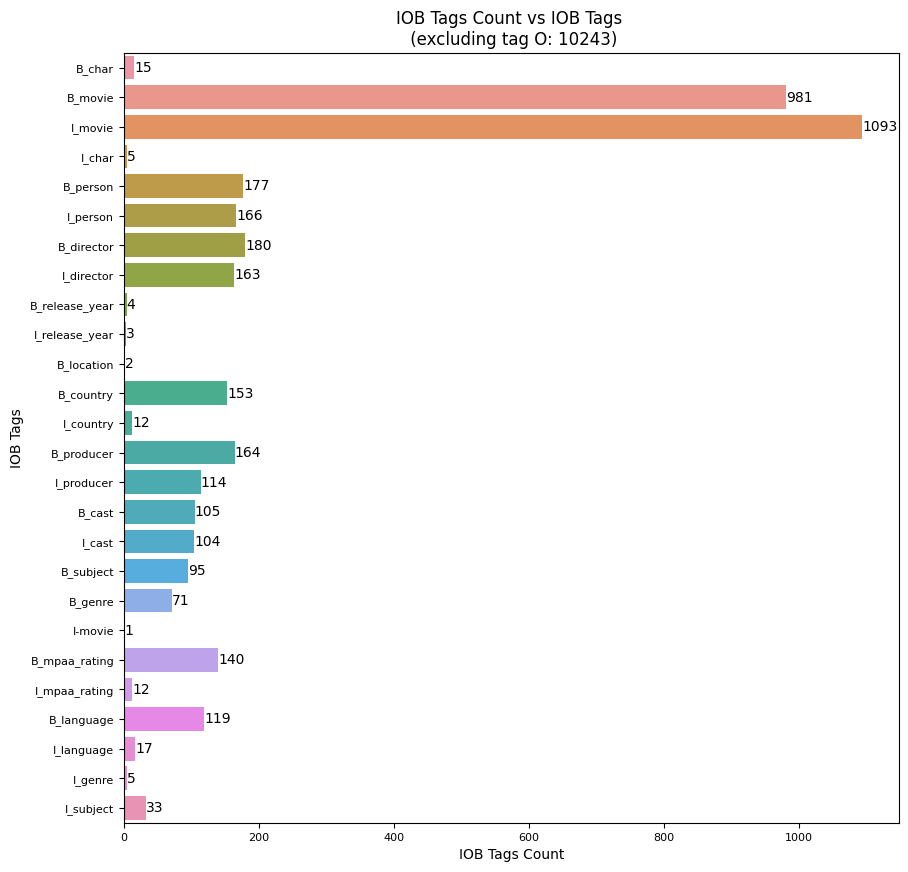

In [32]:
# Representation of Tags in the Dataset
tag_names = list(tag_count_dict.keys())
o_tag = tag_names.pop(0)

tag_count = list(tag_count_dict.values())
o_tag_count = tag_count.pop(0)

tag_df = pd.DataFrame({"iob_tags_count": tag_count, "iob_tags": tag_names})
plt.figure(figsize = (10, 10))
splot = sns.barplot(x = "iob_tags_count", y = "iob_tags" , data = tag_df, orient ='h')
splot.bar_label(splot.containers[0], color='black')
plt.xlabel("IOB Tags Count", size = 10)
plt.ylabel("IOB Tags", size = 10)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.title("IOB Tags Count vs IOB Tags \n (excluding tag %s: %d)" %(o_tag, o_tag_count))

plt.savefig('Images/tag_count.png')

In [78]:
# SlotTagger Class for DataLoader
class SlotTaggerDataset(Dataset):
    
    def __init__(self, 
                 data: pd.DataFrame):
        self.data = data
        self.texts = self.data['texts']
        if 'tags' in self.data.columns:
            self.tags = self.data['tags']
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, 
                    idx: int):
        # Enoding Text
        text = self.texts.iloc[idx]
        encoded_text = self.encode_text(text)
        
        # Encoding Tags if they exist
        if 'tags' in self.data.columns:
            tag = self.tags.iloc[idx]
            encoded_tag = self.encode_tag(tag)
            return encoded_text, encoded_tag 
        else:
            return encoded_text
        
    # Tokenize    
    def tokenize(self, 
                 text: str):
        return [i.text for i in tokenizer(text)]
    
    # Encode Text
    def encode_text(self, 
                    text):
        text_list = [word for word in self.tokenize(text)]
        text_vector = []
        for word in text_list:
            if word in word2idx:
                text_vector.append(word2idx[word])
            else:
                text_vector.append(1)
        return text_vector
    
    # Enocde Tags
    def encode_tag(self, 
                   tag):
        tag_list = [word for word in self.tokenize(tag)]
        tag_vector = [tag2idx[word] for word in tag_list]
        return tag_vector

In [79]:
# Slot Tagger Object for DataLoader
train_ds = SlotTaggerDataset(train_data)

val_ds = SlotTaggerDataset(val_data)

test_ds = SlotTaggerDataset(test_data)
print(test_ds[0])

[1607, 7, 87874]


In [35]:
# Custom Collate function
def custom_collate_fn(batch):
    if isinstance(batch[0], list):
        texts_tensor = [torch.tensor(text) for text in batch]

        lengths = [len(text) for text in batch]
        lengths = torch.tensor(lengths)

        texts_padded = pad_sequence(texts_tensor, batch_first = True, padding_value = 0)

        return texts_padded, lengths

    else:
        texts, tags = zip(*batch)

        texts_tensor = [torch.tensor(text) for text in texts]
        tags_tensor = [torch.tensor(tag) for tag in tags]

        lengths = [len(text) for text in texts]
        lengths = torch.tensor(lengths)

        texts_padded = pad_sequence(texts_tensor, batch_first = True, padding_value = 0)
        tags_padded = pad_sequence(tags_tensor, batch_first = True, padding_value = 0)

        return texts_padded, tags_padded, lengths

BATCH_SIZE = 32

# PyTorch Data Loaders
train_loader = DataLoader(train_ds, 
                          batch_size = BATCH_SIZE, 
                          shuffle = True, 
                          collate_fn = custom_collate_fn)
val_loader = DataLoader(val_ds, 
                        batch_size = BATCH_SIZE, 
                        shuffle = True, 
                        collate_fn = custom_collate_fn)

test_loader = DataLoader(test_ds, 
                        batch_size = 1, 
                        shuffle = False, 
                        collate_fn = custom_collate_fn)

assert train_data.shape[0] == len(train_loader.dataset)
assert val_data.shape[0] == len(val_loader.dataset)
assert test_data.shape[0] == len(test_loader.dataset)

In [57]:
# Bi-LSTM Model
class LSTM(nn.Module):
    
    def __init__(self, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 n_layers, 
                 bidirectional, 
                 dropout):
        super().__init__()
        # Initialize Embedding Layer with Pre-Trained Embeddings (Vector Sequences)
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embeddings).float())
        # Initialzie LSTM layer to process the vector sequences 
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout,
                            batch_first = True)
        num_directions = 2 if bidirectional else 1
        # Initialize Dense layers to predict
        self.fc1 = nn.Linear(hidden_dim * num_directions, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        # Initialize dropout to improve with regularization
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, 
                x, 
                x_lengths):
        # Embedding Layer
        embedded = self.embedding(x)
        # Dropout Layer before LSTM Layer
        embedded = self.dropout(embedded)
        # Packed Sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, 
                                                            x_lengths, 
                                                            batch_first = True, 
                                                            enforce_sorted = False)
        # LSTM Layer
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # Unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, 
                                                                  batch_first = True)
        # 1st Fully Connected Layer
        output = self.fc1(output)
        # Dropout Layer before Output
        output = self.dropout(output)
        # 2nd Fully Connected Layer
        output = self.fc2(output)
        return output

In [67]:
torch.manual_seed(32)

# Model Hyper-parameters
EMBEDDING_DIM = embeddings.shape[1]
HIDDEN_DIM = 20
OUTPUT_DIM = TAG_COUNT
NUM_LAYERS = 2
BIDIRECTION = True
DROPOUT = 0.2

model = LSTM(EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            NUM_LAYERS, 
            BIDIRECTION, 
            DROPOUT).to(device)

print('LSTM Model: ', model)

LSTM Model:  LSTM(
  (embedding): Embedding(2196011, 300)
  (lstm): LSTM(300, 20, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=40, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=27, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [68]:
def squeezed_list(my_list):
    temp_list = [int(element) for element in my_list]
    return temp_list  

def slice_list(my_list, slice_increment):
    return [my_list[i : i + slice_increment] for i in range(0, len(my_list), slice_increment)]

def convert_idx_to_tags(lol, isTensor):
    iob_list = []
    for list_element in lol:
        if (isTensor):
            list_element = list_element.numpy() 
        iob = [idx2tag[index] for index in list_element]
        iob_list.append(iob)
    return iob_list

In [69]:
# Model Train Function
def train(loader, 
          model, 
          optimizer, 
          loss_fn):
    model.train()
    losses = []
    pbar = tqdm(loader)
    for x, y, lengths in pbar:
        optimizer.zero_grad()
        
        # Calculate y_pred
        y_pred = model(x, lengths)
        
        # Convert y_pred to 2D Tensor
        y_pred = y_pred.view(-1, y_pred.shape[-1])
        # Convert y_pred to 1D Tensor
        y = torch.flatten(y)
        
        loss = loss_fn(y_pred, y)
        pbar.set_postfix({'Loss': loss.item()})
        losses.append(loss.item())
        
        # Calculate gradients for w/b
        loss.backward()  
        # Update weights according to optimizer rules
        optimizer.step()          
    return round((sum(losses) / len(losses)), 4)

# Model Evaluate Function
def evaluate(loader, 
             model, 
             loss_fn, 
             score_fn):
    model.eval()
    losses = []
    for x, y, lengths in tqdm(loader):
        y_pred = model(x, lengths)
        
        max_len = x.shape[1]
              
        # Convert y_pred to 2D Tensor
        y_pred = y_pred.view(-1, y_pred.shape[-1])
        # Convert y_pred to 1D Tensor
        y = torch.flatten(y)
        
        loss = loss_fn(y_pred, y)
        losses.append(loss.item())
        
        tags_iob = convert_idx_to_tags(slice_list(y, max_len), True)

        max_preds = y_pred.argmax(dim = 1, keepdim = True) # Get the index of the max probability
        predictions_iob = convert_idx_to_tags(slice_list((squeezed_list(max_preds)), max_len), False)
    
    score = score_fn(tags_iob, predictions_iob, scheme = IOB2)
    return tags_iob, predictions_iob, round((sum(losses) / len(losses)), 4), round(score, 4)

In [70]:
# Model Training on Train dataset and Evaluation on Validation dataset
optimizer = torch.optim.AdamW(model.parameters(),
                              lr = 0.01)
loss_fn = nn.CrossEntropyLoss().to(device)
score_fn = f1_score

train_loss_list = []
val_loss_list = []
f1_score_list = []
n_epochs = 100
best_acc = 0
PATH = f'best-model.pt'

for epoch in range(n_epochs):
    # Model Training
    train_loss = train(train_loader, 
                     model, 
                     optimizer, 
                     loss_fn)
    train_loss_list.append(train_loss)
    print('Train Loss: ', train_loss)
    
    # Model Evaluation
    tags, predictions, val_loss, accuracy = evaluate(val_loader, 
                                                       model, 
                                                       loss_fn, 
                                                       score_fn)
    val_loss_list.append(val_loss)
    f1_score_list.append(accuracy)
    print('Val Accuracy: ', accuracy)
    print('Val Loss: ', val_loss)
    
    # Save model if Validation F1_Score is greather than 75%
    if accuracy > best_acc and accuracy > 0.75:
        torch.save(model.state_dict(), PATH)

100%|███████████████████████████████| 53/53 [00:00<00:00, 87.03it/s, Loss=0.402]


Train Loss:  1.3077


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 225.26it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_movie seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_movie seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_genre seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_producer seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seq

Val Accuracy:  0.6316
Val Loss:  0.3788


100%|██████████████████████████████| 53/53 [00:00<00:00, 103.72it/s, Loss=0.155]


Train Loss:  0.304


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 248.52it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_person seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_person seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_subject seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_char seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Val Accuracy:  0.6842
Val Loss:  0.2325


100%|██████████████████████████████| 53/53 [00:00<00:00, 105.33it/s, Loss=0.246]


Train Loss:  0.2039


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 245.14it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mpaa_rating seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_cast seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Val Accuracy:  0.7467
Val Loss:  0.185


100%|██████████████████████████████| 53/53 [00:00<00:00, 105.86it/s, Loss=0.088]


Train Loss:  0.1511


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 254.51it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_cast seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Val Accuracy:  0.8395
Val Loss:  0.1695


100%|██████████████████████████████| 53/53 [00:00<00:00, 95.96it/s, Loss=0.0797]


Train Loss:  0.1272


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 239.27it/s]


Val Accuracy:  0.9136
Val Loss:  0.1321


100%|██████████████████████████████| 53/53 [00:00<00:00, 101.04it/s, Loss=0.111]


Train Loss:  0.099


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 249.53it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_char seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Val Accuracy:  0.7711
Val Loss:  0.1341


100%|█████████████████████████████| 53/53 [00:00<00:00, 100.58it/s, Loss=0.0282]


Train Loss:  0.0857


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 240.91it/s]


Val Accuracy:  0.8205
Val Loss:  0.1181


100%|█████████████████████████████| 53/53 [00:00<00:00, 102.41it/s, Loss=0.0823]


Train Loss:  0.0711


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 270.23it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_country seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Val Accuracy:  0.7532
Val Loss:  0.1135


100%|██████████████████████████████| 53/53 [00:00<00:00, 104.91it/s, Loss=0.102]


Train Loss:  0.065


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 261.13it/s]


Val Accuracy:  0.9114
Val Loss:  0.1021


100%|█████████████████████████████| 53/53 [00:00<00:00, 102.99it/s, Loss=0.0533]


Train Loss:  0.0514


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 244.24it/s]


Val Accuracy:  0.9474
Val Loss:  0.1108


100%|█████████████████████████████| 53/53 [00:00<00:00, 105.13it/s, Loss=0.0509]


Train Loss:  0.0526


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 253.93it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_mpaa_rating seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Val Accuracy:  0.9744
Val Loss:  0.114


100%|█████████████████████████████| 53/53 [00:00<00:00, 105.47it/s, Loss=0.0331]


Train Loss:  0.0441


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 259.52it/s]


Val Accuracy:  0.9333
Val Loss:  0.1134


100%|█████████████████████████████| 53/53 [00:00<00:00, 104.85it/s, Loss=0.0345]


Train Loss:  0.0395


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 267.26it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_language seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Val Accuracy:  0.8537
Val Loss:  0.1053


100%|█████████████████████████████| 53/53 [00:00<00:00, 103.67it/s, Loss=0.0561]


Train Loss:  0.0404


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 250.92it/s]


Val Accuracy:  0.9474
Val Loss:  0.1067


100%|██████████████████████████████| 53/53 [00:00<00:00, 79.98it/s, Loss=0.0581]


Train Loss:  0.037


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 252.64it/s]


Val Accuracy:  0.9589
Val Loss:  0.098


100%|█████████████████████████████| 53/53 [00:00<00:00, 104.27it/s, Loss=0.0674]


Train Loss:  0.0299


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 252.44it/s]


Val Accuracy:  0.9211
Val Loss:  0.1057


100%|█████████████████████████████| 53/53 [00:00<00:00, 106.07it/s, Loss=0.0114]


Train Loss:  0.0273


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 260.10it/s]


Val Accuracy:  0.8831
Val Loss:  0.1129


100%|█████████████████████████████| 53/53 [00:00<00:00, 107.38it/s, Loss=0.0161]


Train Loss:  0.026


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 258.63it/s]


Val Accuracy:  0.8642
Val Loss:  0.1113


100%|█████████████████████████████| 53/53 [00:00<00:00, 108.06it/s, Loss=0.0118]


Train Loss:  0.0306


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 248.08it/s]


Val Accuracy:  0.9315
Val Loss:  0.1117


100%|█████████████████████████████| 53/53 [00:00<00:00, 105.47it/s, Loss=0.0123]


Train Loss:  0.027


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 260.36it/s]


Val Accuracy:  0.9231
Val Loss:  0.1056


100%|██████████████████████████████| 53/53 [00:00<00:00, 97.44it/s, Loss=0.0784]


Train Loss:  0.0248


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 258.11it/s]


Val Accuracy:  0.8642
Val Loss:  0.1111


100%|███████████████████████████████| 53/53 [00:00<00:00, 98.40it/s, Loss=0.107]


Train Loss:  0.0214


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 243.70it/s]


Val Accuracy:  0.7941
Val Loss:  0.128


100%|██████████████████████████████| 53/53 [00:00<00:00, 102.14it/s, Loss=0.015]


Train Loss:  0.0255


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 249.83it/s]


Val Accuracy:  0.9383
Val Loss:  0.125


100%|█████████████████████████████| 53/53 [00:00<00:00, 107.48it/s, Loss=0.0529]


Train Loss:  0.0268


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 250.82it/s]


Val Accuracy:  0.9286
Val Loss:  0.1293


100%|█████████████████████████████| 53/53 [00:00<00:00, 104.41it/s, Loss=0.0154]


Train Loss:  0.0225


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 267.15it/s]


Val Accuracy:  0.9444
Val Loss:  0.1118


100%|██████████████████████████████| 53/53 [00:00<00:00, 100.37it/s, Loss=0.015]


Train Loss:  0.0215


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 240.03it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_release_year seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Val Accuracy:  0.9367
Val Loss:  0.1175


100%|████████████████████████████| 53/53 [00:00<00:00, 102.69it/s, Loss=0.00489]


Train Loss:  0.0191


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 245.25it/s]


Val Accuracy:  0.9041
Val Loss:  0.118


100%|█████████████████████████████| 53/53 [00:00<00:00, 96.53it/s, Loss=0.00465]


Train Loss:  0.0211


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 226.29it/s]


Val Accuracy:  0.8608
Val Loss:  0.1125


100%|████████████████████████████| 53/53 [00:00<00:00, 106.32it/s, Loss=0.00904]


Train Loss:  0.0171


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 233.31it/s]


Val Accuracy:  0.925
Val Loss:  0.1195


100%|█████████████████████████████| 53/53 [00:00<00:00, 103.78it/s, Loss=0.0145]


Train Loss:  0.0171


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 259.54it/s]


Val Accuracy:  0.9024
Val Loss:  0.1233


100%|████████████████████████████| 53/53 [00:00<00:00, 105.49it/s, Loss=0.00184]


Train Loss:  0.0149


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 278.53it/s]


Val Accuracy:  0.8831
Val Loss:  0.118


100%|████████████████████████████| 53/53 [00:00<00:00, 105.15it/s, Loss=0.00372]


Train Loss:  0.015


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 260.29it/s]


Val Accuracy:  0.85
Val Loss:  0.1224


100%|████████████████████████████| 53/53 [00:00<00:00, 106.99it/s, Loss=0.00404]


Train Loss:  0.0175


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 262.60it/s]


Val Accuracy:  0.9459
Val Loss:  0.1327


100%|█████████████████████████████| 53/53 [00:00<00:00, 105.58it/s, Loss=0.0248]


Train Loss:  0.0175


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 268.24it/s]


Val Accuracy:  0.961
Val Loss:  0.1193


100%|█████████████████████████████| 53/53 [00:00<00:00, 107.50it/s, Loss=0.0177]


Train Loss:  0.0129


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 261.27it/s]


Val Accuracy:  0.9487
Val Loss:  0.1306


100%|████████████████████████████| 53/53 [00:00<00:00, 107.35it/s, Loss=0.00782]


Train Loss:  0.0164


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 273.59it/s]


Val Accuracy:  0.7805
Val Loss:  0.1307


100%|█████████████████████████████| 53/53 [00:00<00:00, 108.55it/s, Loss=0.0278]


Train Loss:  0.0135


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 251.36it/s]


Val Accuracy:  0.9286
Val Loss:  0.1194


100%|████████████████████████████| 53/53 [00:00<00:00, 105.19it/s, Loss=0.00351]


Train Loss:  0.0183


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 243.27it/s]


Val Accuracy:  0.8916
Val Loss:  0.1339


100%|████████████████████████████| 53/53 [00:00<00:00, 106.65it/s, Loss=0.00937]


Train Loss:  0.0181


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 251.19it/s]


Val Accuracy:  1.0
Val Loss:  0.1232


100%|████████████████████████████| 53/53 [00:00<00:00, 107.55it/s, Loss=0.00876]


Train Loss:  0.0179


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 247.02it/s]


Val Accuracy:  0.8947
Val Loss:  0.1256


100%|████████████████████████████| 53/53 [00:00<00:00, 107.25it/s, Loss=0.00691]


Train Loss:  0.0132


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 256.47it/s]


Val Accuracy:  0.9737
Val Loss:  0.1187


100%|█████████████████████████████| 53/53 [00:00<00:00, 107.32it/s, Loss=0.0194]


Train Loss:  0.0153


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 261.83it/s]


Val Accuracy:  0.9136
Val Loss:  0.1135


100%|█████████████████████████████| 53/53 [00:00<00:00, 109.49it/s, Loss=0.0186]


Train Loss:  0.0146


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 258.46it/s]


Val Accuracy:  0.961
Val Loss:  0.1096


100%|█████████████████████████████| 53/53 [00:00<00:00, 108.77it/s, Loss=0.0246]


Train Loss:  0.0121


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 262.69it/s]


Val Accuracy:  0.963
Val Loss:  0.11


100%|█████████████████████████████| 53/53 [00:00<00:00, 106.63it/s, Loss=0.0021]


Train Loss:  0.0122


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 257.45it/s]


Val Accuracy:  0.975
Val Loss:  0.1318


100%|█████████████████████████████| 53/53 [00:00<00:00, 105.51it/s, Loss=0.0106]


Train Loss:  0.0151


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 248.77it/s]


Val Accuracy:  0.975
Val Loss:  0.1308


100%|█████████████████████████████| 53/53 [00:00<00:00, 102.36it/s, Loss=0.0108]


Train Loss:  0.0147


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 258.07it/s]


Val Accuracy:  0.9487
Val Loss:  0.1128


100%|█████████████████████████████| 53/53 [00:00<00:00, 104.26it/s, Loss=0.0113]


Train Loss:  0.015


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 251.01it/s]


Val Accuracy:  0.9067
Val Loss:  0.1126


100%|████████████████████████████| 53/53 [00:00<00:00, 106.42it/s, Loss=0.00678]


Train Loss:  0.0119


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 259.50it/s]


Val Accuracy:  0.9383
Val Loss:  0.131


100%|█████████████████████████████| 53/53 [00:00<00:00, 106.40it/s, Loss=0.0162]


Train Loss:  0.0172


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 263.10it/s]


Val Accuracy:  0.987
Val Loss:  0.1235


100%|█████████████████████████████| 53/53 [00:00<00:00, 105.89it/s, Loss=0.0105]


Train Loss:  0.0159


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 263.48it/s]


Val Accuracy:  1.0
Val Loss:  0.1257


100%|██████████████████████████████| 53/53 [00:00<00:00, 107.52it/s, Loss=0.026]


Train Loss:  0.0141


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 254.63it/s]


Val Accuracy:  0.9487
Val Loss:  0.1307


100%|█████████████████████████████| 53/53 [00:00<00:00, 111.38it/s, Loss=0.0226]


Train Loss:  0.017


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 261.62it/s]


Val Accuracy:  1.0
Val Loss:  0.1155


100%|████████████████████████████| 53/53 [00:00<00:00, 111.48it/s, Loss=0.00276]


Train Loss:  0.0174


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 265.83it/s]


Val Accuracy:  0.9231
Val Loss:  0.1089


100%|████████████████████████████| 53/53 [00:00<00:00, 106.77it/s, Loss=0.00852]


Train Loss:  0.0148


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 261.96it/s]


Val Accuracy:  0.9136
Val Loss:  0.1163


100%|█████████████████████████████| 53/53 [00:00<00:00, 106.68it/s, Loss=0.0096]


Train Loss:  0.0118


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 259.70it/s]


Val Accuracy:  0.96
Val Loss:  0.1145


100%|█████████████████████████████| 53/53 [00:00<00:00, 106.30it/s, Loss=0.0258]


Train Loss:  0.0102


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 259.68it/s]


Val Accuracy:  0.962
Val Loss:  0.1273


100%|████████████████████████████| 53/53 [00:00<00:00, 107.43it/s, Loss=0.00727]


Train Loss:  0.0164


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 244.07it/s]


Val Accuracy:  0.925
Val Loss:  0.1196


100%|████████████████████████████| 53/53 [00:00<00:00, 105.98it/s, Loss=0.00135]


Train Loss:  0.0115


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 254.77it/s]


Val Accuracy:  0.9744
Val Loss:  0.1244


100%|████████████████████████████| 53/53 [00:00<00:00, 106.46it/s, Loss=0.00294]


Train Loss:  0.0121


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 264.69it/s]


Val Accuracy:  0.9383
Val Loss:  0.1272


100%|████████████████████████████| 53/53 [00:00<00:00, 113.74it/s, Loss=0.00461]


Train Loss:  0.0138


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 260.05it/s]


Val Accuracy:  0.9333
Val Loss:  0.123


100%|████████████████████████████| 53/53 [00:00<00:00, 107.86it/s, Loss=0.00231]


Train Loss:  0.0107


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 259.82it/s]


Val Accuracy:  0.9231
Val Loss:  0.1443


100%|█████████████████████████████| 53/53 [00:00<00:00, 107.11it/s, Loss=0.0115]


Train Loss:  0.0135


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 257.87it/s]


Val Accuracy:  0.8974
Val Loss:  0.1212


100%|█████████████████████████████| 53/53 [00:00<00:00, 107.82it/s, Loss=0.0043]


Train Loss:  0.0106


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 267.93it/s]


Val Accuracy:  0.988
Val Loss:  0.1204


100%|████████████████████████████| 53/53 [00:00<00:00, 106.25it/s, Loss=0.00323]


Train Loss:  0.0144


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 258.90it/s]


Val Accuracy:  0.9383
Val Loss:  0.1026


100%|████████████████████████████| 53/53 [00:00<00:00, 107.64it/s, Loss=0.00779]


Train Loss:  0.0141


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 265.41it/s]


Val Accuracy:  0.9744
Val Loss:  0.1059


100%|█████████████████████████████| 53/53 [00:00<00:00, 108.84it/s, Loss=0.0374]


Train Loss:  0.0141


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 267.55it/s]


Val Accuracy:  0.975
Val Loss:  0.1094


100%|█████████████████████████████| 53/53 [00:00<00:00, 107.10it/s, Loss=0.0103]


Train Loss:  0.0128


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 267.36it/s]


Val Accuracy:  0.9114
Val Loss:  0.1123


100%|████████████████████████████| 53/53 [00:00<00:00, 107.61it/s, Loss=0.00863]


Train Loss:  0.0109


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 266.98it/s]


Val Accuracy:  0.9
Val Loss:  0.1306


100%|█████████████████████████████| 53/53 [00:00<00:00, 105.66it/s, Loss=0.0111]


Train Loss:  0.01


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 255.04it/s]


Val Accuracy:  0.961
Val Loss:  0.1141


100%|████████████████████████████| 53/53 [00:00<00:00, 105.79it/s, Loss=0.00253]


Train Loss:  0.0085


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 263.91it/s]


Val Accuracy:  0.9351
Val Loss:  0.1354


100%|█████████████████████████████| 53/53 [00:00<00:00, 107.31it/s, Loss=0.0105]


Train Loss:  0.0102


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 254.82it/s]


Val Accuracy:  0.961
Val Loss:  0.1201


100%|████████████████████████████| 53/53 [00:00<00:00, 106.68it/s, Loss=0.00391]


Train Loss:  0.0122


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 258.10it/s]


Val Accuracy:  0.9863
Val Loss:  0.1229


100%|████████████████████████████| 53/53 [00:00<00:00, 107.13it/s, Loss=0.00219]


Train Loss:  0.0129


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 264.79it/s]


Val Accuracy:  0.9136
Val Loss:  0.1015


100%|█████████████████████████████| 53/53 [00:00<00:00, 106.62it/s, Loss=0.0103]


Train Loss:  0.011


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 254.17it/s]


Val Accuracy:  0.8675
Val Loss:  0.1062


100%|█████████████████████████████| 53/53 [00:00<00:00, 105.62it/s, Loss=0.0196]


Train Loss:  0.0105


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 264.35it/s]


Val Accuracy:  0.9351
Val Loss:  0.1049


100%|█████████████████████████████| 53/53 [00:00<00:00, 107.46it/s, Loss=0.0362]


Train Loss:  0.0115


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 259.72it/s]


Val Accuracy:  1.0
Val Loss:  0.1169


100%|████████████████████████████| 53/53 [00:00<00:00, 107.59it/s, Loss=0.00256]


Train Loss:  0.0106


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 260.02it/s]


Val Accuracy:  0.8767
Val Loss:  0.1363


100%|████████████████████████████| 53/53 [00:00<00:00, 105.88it/s, Loss=0.00205]


Train Loss:  0.0118


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 261.66it/s]


Val Accuracy:  0.962
Val Loss:  0.1229


100%|████████████████████████████| 53/53 [00:00<00:00, 108.09it/s, Loss=0.00661]


Train Loss:  0.0104


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 253.21it/s]


Val Accuracy:  0.878
Val Loss:  0.1327


100%|████████████████████████████| 53/53 [00:00<00:00, 111.06it/s, Loss=0.00233]


Train Loss:  0.0105


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 246.79it/s]


Val Accuracy:  0.8434
Val Loss:  0.1141


100%|█████████████████████████████| 53/53 [00:00<00:00, 106.77it/s, Loss=0.0112]


Train Loss:  0.0116


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 260.87it/s]


Val Accuracy:  0.9114
Val Loss:  0.1151


100%|█████████████████████████████| 53/53 [00:00<00:00, 106.22it/s, Loss=0.0136]


Train Loss:  0.0109


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 262.30it/s]


Val Accuracy:  0.96
Val Loss:  0.1333


100%|████████████████████████████| 53/53 [00:00<00:00, 108.17it/s, Loss=0.00259]


Train Loss:  0.012


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 263.94it/s]


Val Accuracy:  0.9231
Val Loss:  0.1204


100%|█████████████████████████████| 53/53 [00:00<00:00, 107.76it/s, Loss=0.0121]


Train Loss:  0.0098


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 252.61it/s]


Val Accuracy:  0.9091
Val Loss:  0.1253


100%|████████████████████████████| 53/53 [00:00<00:00, 106.60it/s, Loss=0.00561]


Train Loss:  0.011


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 266.49it/s]


Val Accuracy:  0.96
Val Loss:  0.1093


100%|█████████████████████████████| 53/53 [00:00<00:00, 107.39it/s, Loss=0.0361]


Train Loss:  0.0068


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 258.51it/s]


Val Accuracy:  0.975
Val Loss:  0.1115


100%|█████████████████████████████| 53/53 [00:00<00:00, 107.26it/s, Loss=0.0126]


Train Loss:  0.0096


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 256.25it/s]


Val Accuracy:  0.9737
Val Loss:  0.1171


100%|█████████████████████████████| 53/53 [00:00<00:00, 105.89it/s, Loss=0.0081]


Train Loss:  0.007


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 262.42it/s]


Val Accuracy:  0.9167
Val Loss:  0.114


100%|████████████████████████████| 53/53 [00:00<00:00, 106.27it/s, Loss=0.00276]


Train Loss:  0.0098


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 260.19it/s]


Val Accuracy:  0.9459
Val Loss:  0.1179


100%|█████████████████████████████| 53/53 [00:00<00:00, 106.43it/s, Loss=0.0119]


Train Loss:  0.009


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 265.75it/s]


Val Accuracy:  0.9024
Val Loss:  0.1334


100%|████████████████████████████| 53/53 [00:00<00:00, 101.37it/s, Loss=0.00116]


Train Loss:  0.0097


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 252.03it/s]


Val Accuracy:  0.9
Val Loss:  0.1475


100%|████████████████████████████| 53/53 [00:00<00:00, 108.16it/s, Loss=0.00705]


Train Loss:  0.0136


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 262.64it/s]


Val Accuracy:  1.0
Val Loss:  0.1325


100%|█████████████████████████████| 53/53 [00:00<00:00, 105.82it/s, Loss=0.0112]


Train Loss:  0.0124


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 260.78it/s]


Val Accuracy:  0.9041
Val Loss:  0.1412


100%|█████████████████████████████| 53/53 [00:00<00:00, 103.94it/s, Loss=0.0144]


Train Loss:  0.0114


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 258.65it/s]


Val Accuracy:  0.9
Val Loss:  0.1388


100%|████████████████████████████| 53/53 [00:00<00:00, 105.64it/s, Loss=0.00954]


Train Loss:  0.012


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 261.49it/s]


Val Accuracy:  0.8947
Val Loss:  0.141


100%|████████████████████████████| 53/53 [00:00<00:00, 105.90it/s, Loss=0.00713]


Train Loss:  0.0085


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 263.12it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_release_year seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Val Accuracy:  0.9333
Val Loss:  0.136


100%|████████████████████████████| 53/53 [00:00<00:00, 105.95it/s, Loss=0.00114]


Train Loss:  0.0119


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 242.04it/s]


Val Accuracy:  1.0
Val Loss:  0.1318


100%|█████████████████████████████| 53/53 [00:00<00:00, 105.45it/s, Loss=0.0549]


Train Loss:  0.0104


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 266.19it/s]


Val Accuracy:  0.8378
Val Loss:  0.1467


100%|████████████████████████████| 53/53 [00:00<00:00, 103.65it/s, Loss=0.00115]


Train Loss:  0.0103


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 264.00it/s]


Val Accuracy:  0.8718
Val Loss:  0.1424


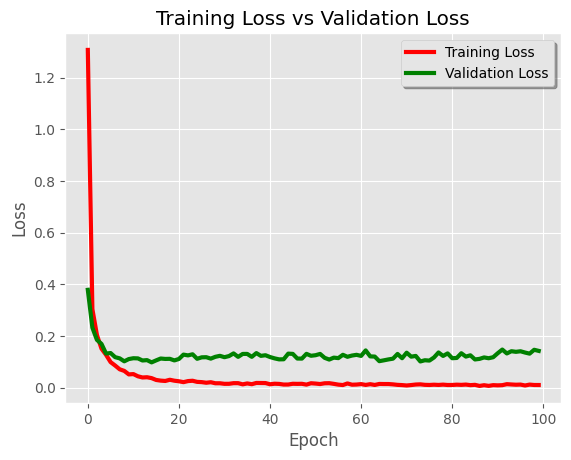

In [71]:
# Training vs Validation Loss Plot
epochs = np.arange(n_epochs)  

plt.style.use('ggplot')
plt.plot(epochs, train_loss_list, label = "Training Loss", color = "red", linewidth = '3')
plt.plot(epochs, val_loss_list, label = "Validation Loss", color = "green", linewidth = '3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss', color = 'black')
plt.legend(shadow = True, labelcolor = 'black')
plt.savefig('Images/train_vs_val_loss_plot.png')

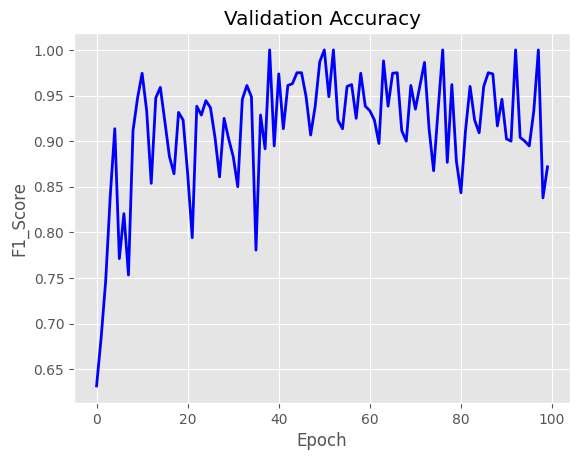

In [72]:
# Validation Accuracy Plot
plt.plot(epochs, f1_score_list, color = 'blue', linewidth = '2')
plt.xlabel('Epoch')
plt.ylabel('F1_Score')
plt.title('Validation Accuracy', color = 'black')
plt.savefig('Images/f1_accuracy_plot.png')

In [73]:
# Load the saved model
saved_model = LSTM(EMBEDDING_DIM, 
                   HIDDEN_DIM, 
                   OUTPUT_DIM, 
                   NUM_LAYERS, 
                   BIDIRECTION, 
                   DROPOUT).to(device)

saved_model.load_state_dict(torch.load(PATH))
saved_model.eval()

LSTM(
  (embedding): Embedding(2196011, 300)
  (lstm): LSTM(300, 20, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=40, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=27, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [74]:
# Model Predict Function
def predict(loader, 
            model):
    predictions = []
    for x, lengths in tqdm(loader):
        with torch.no_grad():
            y_pred = saved_model.forward(x, lengths)
            
            max_len = x.shape[1]

            # Convert y_pred to 2D Tensor
            y_pred = y_pred.view(-1, y_pred.shape[-1])

            max_preds = y_pred.argmax(dim = 1, keepdim = True) # Get the index of the max probability
            predictions_iob = convert_idx_to_tags(slice_list((squeezed_list(max_preds)), max_len), False)
            predictions.append(predictions_iob)
    
    return predictions

predicted_tags = predict(test_loader, saved_model)
predicted_tags = np.array(predicted_tags)
predicted_tags = predicted_tags.squeeze().tolist()

100%|███████████████████████████████████████| 981/981 [00:00<00:00, 1899.68it/s]
/var/folders/hk/l7897jp170bb9tbb20n80tz00000gn/T/ipykernel_27795/242441740.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predicted_tags = np.array(predicted_tags)


In [81]:
# Creating Dictionary of Predictions
list_of_dict = []
for i in range(len(predicted_tags)):
    temp_dict = {}
    temp_dict["ID"] = i
    temp_dict["IOB Slot tags"] = ' '.join(predicted_tags[i])
    list_of_dict.append(temp_dict)

# Converting Dictionary to CSV and compress it for submission to CodaLab
tags_df = pd.DataFrame.from_dict(list_of_dict)
tags_df.to_csv('submission.csv.zip', compression = 'zip', index = False)
print(tags_df)

      ID                                      IOB Slot tags
0      0                                        O O B_movie
1      1                          O O O O O B_movie I_movie
2      2                        O O O O O O B_movie I_movie
3      3                                      O O O B_movie
4      4                                      O O O B_movie
..   ...                                                ...
976  976        O O B_movie I_movie I_movie I_movie I_movie
977  977                            O B_movie I_movie O O O
978  978                O O O O O O I_producer I_producer O
979  979  O O B_director I_director O O O O B_movie I_mo...
980  980                   O O B_director O O O O B_country

[981 rows x 2 columns]
